# QSP Notebook - Simulation demo

-----------------------

## What is QSP Notebook?

QSP Notebook is a proprietary Python package that converts tables of parameters and doses into arrays of simulations, then runs those simulations and stores the result in a table that's ready for plotting or further analysis. It's meant to make running larger numbers of simulations more straightforward. 

----------------------------

## Getting up and running

### How do I download QSP Notebook?

You don't have to download anything! Just import the `abm` module.

### How do I use the python simulation framework in a notebook?
To use QSP Notebook, you need to import it. You need to do this at the beginning of every notebook that uses it.

In [1]:
# Import QSP Notebook
import abm

# Also import other packages
# Numpy
import numpy as np
# Pandas
import pandas as pd
# Plotnine (ggplot for Python)
import plotnine as p9
import copy

### What features does QSP Notebook have?
QSP Notebook has three primary features:

1. Run simulations
2. Run simulations that scan parameters
3. Optimize parameters

To demo these features, We will use an in-vivo single receptor binding model. You may load this model as shown below, and interact with its attributes.

To see how QSP Notebook works, in this Jupyter notebook we will set up a series of simulations simulating the binding kinetics of a strong and weak binder for a large and small amount of receptor. We will simulate many doses to generate four dose response curves, one for each binding strength / receptor burden combination.

--------------

## Running simulations

To run simulations, you need to configure a **simulation table** that defines the simulations you want to run, as well as a **parameter table** and a **dose table** to indicate which parameters and doses to use for each simulation. Optional tables include a **model table** and a **times table** to indicate which model files and output times are used for each simulation. Each of these tables needs to be a Pandas/Polars/Tabeline dataframe or a csv file.

CSV files (or any file) can be directly uploaded to the JupyterLab server by using the upload button or pushed from a git repo on your local machine. Alternatively, you can author and edit CSV files within JupyterLab.

### Simulation table

The simulation table is where we describe the simulations we would like to run. It may have any number of columns with any name. Each row of the simulation table should uniquely identify a single simulation. 

The simulation table is best understood via example. In this case, we want to simulate a handful of doses for all four combinations of strong or weak binders and low or high receptor burdens. We set up the simulation table with three columns: `dose_mpk` to encode the dose level, `binding_strength` to encode the binder used, and `burden` to encode the receptor burden. These columns can be either strings or numbers. The parameter and dose tables will specify exactly what these descriptive columns represent in terms of parameters and doses.

In [2]:
Tsim = pd.read_csv("tables/sim_table_psf.csv")

display(Tsim.head())

,dose_mpk,binding_strength,burden
0,0.00001,strong,low
1,0.00001,strong,high
2,0.00001,weak,low
3,0.00001,weak,high
4,0.00002,strong,low


### Parameter table

The parameter table is where we define which parameters apply to each of the rows in the simulation table. The parameter table has three mandatory columns:

1. `parameter`, a column of strings indicating model parameter names
2. `value`, a column of numbers indicating model parameter values
3. `unit`, a column of strings indicating the model parameter units; a list of available units are in the antireceptor model files.

In addition to the mandatory columns, a parameter table can have additional label columns that match the column names in the simulation table to indicate the different values that a parameter can take. In this case, our parameter table contains two columns, `binding_strength` and `burden`, that match the column names in the simulation table. This columns indicate the binding strengths and receptor burdens that each specified parameter should belong to. In cases where the parameter should be used for any value of the label column, we can specify an `*`. 

In [3]:
Tpar = pd.read_csv("./tables/par_table_psf.csv")
display(Tpar)

,binding_strength,burden,parameter,value,unit
0,*,*,volume_central,5.000000e+00,L
1,*,low,R1_per_cell,1.000000e+04,1
2,*,high,R1_per_cell,1.000000e+06,1
3,*,*,cell_per_mL,1.000000e+04,(1/mL)
4,*,*,kon,1.000000e-03,(1/nM/s)
5,strong,*,kd_mab,1.000000e-01,nM
6,weak,*,kd_mab,2.000000e+00,nM
7,*,*,el_half,2.800000e+01,d
8,*,*,abs_half,2.500000e+00,d
9,*,*,R1_half,6.000000e+01,min


`volume_central`, `cell_per_mL`, `kon`, `el_half`, `abs_half`, `R1_half`, `BW`, `mw`, `interval`, `dose`, `dose_count`, `Thalf_cytokine_h`, `RO50_perc`, and `ksecrete_max_nmolpercellsec` are set to be the same for all simulations, while `kd_mab` depends on the `binding_strength` and `R1_per_cell` depends on the burden.

### Dose table

The dose table works similarly to the parameter table but specifies doses instead of parameters. It has five mandatory columns:

1. `route`, a string indicating which dose route to use for the dose
2. `amounts`, a column of numbers or lists of numbers indicating the dose amounts
3. `times`, a column of numbers or lists of numbers indicating the times at which to dose. This allows each separate dose to be implemented at distinct times
4. `amount_unit`, a column of strings indicating the dose units
5. `time_unit`, a column of strings indicating the time units for dosing

For this example, the dose table will have a column called `dose_mpk` to match the dose amount listed in the simulation table. Not all of the simulation table's columns need to appear in the dose table and the parameter table, so I will leave off `binding_strength` and `burden` columns since they shouldn't impact the dose I want to use. Any missing columns are treated as if all rows had asterisks for the column's value. If I did include `binding_strength` and `burden` as columns, I could specify different doses for each binding strength and/or receptor burden.

In [4]:
Tdos = pd.read_csv("./tables/dose_table_psf.csv")

display(Tdos)

,dose_mpk,route,amounts,amount_unit,times,time_unit
0,0.00001,IV_mpk,0.00001,(mg/kg),"[0,21]",d
1,0.00002,IV_mpk,0.00002,(mg/kg),"[0,21]",d
2,0.00005,IV_mpk,0.00005,(mg/kg),"[0,21]",d
3,0.00010,IV_mpk,0.00010,(mg/kg),"[0,21]",d
4,0.00020,IV_mpk,0.00020,(mg/kg),"[0,21]",d
5,0.00050,IV_mpk,0.00050,(mg/kg),"[0,21]",d
6,0.00100,IV_mpk,0.00100,(mg/kg),"[0,21]",d
7,0.00200,IV_mpk,0.00200,(mg/kg),"[0,21]",d
8,0.00500,IV_mpk,0.00500,(mg/kg),"[0,21]",d
9,0.01000,IV_mpk,0.01000,(mg/kg),"[0,21]",d


### Model table

The model table works similarly to the parameter table but specifies model files instead of parameters. It has one mandatory column:

1. `model`, a model file

For this example, the model table will have a column called `burden` to match the burden level listed in the simulation table. Not all of the simulation table's columns need to appear in the model table, so I will leave off `binding_strength` and `dose_mpk` columns. For this example, I will demonstrate how to call two separate model files - one for each burden level. Any missing columns are treated as if all rows had asterisks for the column's value. If I did include `binding_strength` and `dose_mpk` as columns, I could specify different model files for each binding strength and/or dose.

In this particular example the model files describe the exact same model dynamics, so having two separate model files is not necessary. But this will allow us to test this functionality.

In [5]:
Tmod = pd.read_csv("./tables/model_table_psf.csv")

display(Tmod)

,burden,model
0,low,model_files/antireceptor_model_1compartment-1.txt
1,high,model_files/antireceptor_model_1compartment-2.txt


### Times Table

The times table works similarly to the parameter table but specifies output times instead of parameters. It has two mandatory columns:

1. `times`, list of times at which you wish to output simulation results
2. `times_unit`, string defining the output time units

For this example, the times table will have a column called `binding_strength` to match the binding strength listed in the simulation table. Not all of the simulation table's columns need to appear in the model table, so I will leave off `burden` and `dose_mpk` columns. If I did include `burden` and `dose_mpk` as columns, I could specify different output times for each burden and/or dose. 

Note that the package can handle numerical expressions, e.g. 2*86400, as inputs.

In [6]:
Ttime = pd.read_csv("./tables/output_times_table_psf.csv")

display(Ttime)

,binding_strength,times,times_unit
0,strong,"[0, 86400, 2*86400]",s
1,weak,"[1000, 87400, pow(2,3)*20000]",s


### Run the simulations

We're now ready to run the simulations. You may pass the tables as loaded in as pandas DataFrames or pass the directory to those tables. Both methods can be more convenient, depending on what you're doing (e.g. testing the model while building it, it can be helpful to load in the model file directly to minimize the number of cells needed to run).

In [7]:
# abm.linspace creates linearly spaced united quantities and is useful for setting output times.
# This function returns a list of strings setting the output times in days.
fine_times = abm.linspace(0, 2, 21, 'd')

# United quantities are just strings of numbers and units with a colon separating them.
# You can generate them manually as shown below
fine_times_2 = [f"{t}:d" for t in np.arange(0, 2.01, 0.1)]

fine_times == fine_times_2

False

In [8]:
simres = abm.simulate(
    simulations=Tsim, # here you could provide the path to the file containing the simulation table as well.
    models=Tmod,  # here you could provide the path to the file containing the model table as well.
    parameters=Tpar, # here you could provide the path to the file containing the parameter table as well.
    doses=Tdos, # here you could provide the path to the file containing the dose table as well.
    times=fine_times, #["0:s", "1:hr"], # instead of using the Times Table, I used a single array of time outputs for all simulations
    outputs=['cytokine_central_nM'],
    linear_solver="KLU",
    reltol=1e-6,
    abstol=1e-8,
    maxord=5,
    nonnegative=False,
)

/opt/pixi/cache/envs/abm-platform-training-11393412784987863449/envs/default/lib/python3.12/site-packages/abm/_simulate.py:355: UserWarning: Parameters not present in the model will be ignored: nonexist 


Total: 0, Running: 0, Succeeded: 0, Failed: 0

### Getting the output table

### SimulationResult
The output of the simulate function is `SimulationResult` object.

```
class SimulationResult:
    remote_result: RemoteSimulationList
    simulation_list: List[Simulations]
    labels_info_table: tl.DataFrame
    outputs: List[str]
```

This class has the following methods:


* `to_data_pipe(tall_outputs: bool = False) -> RemoteAnalysis`
* `to_data_frame(tall_outputs: bool = False) -> RemoteDataTable`
* `to_tabeline(tall_outputs: bool = False) -> tl.DataFrame`
* `to_pandas(tall_outputs: bool = False) -> pd.DataFrame`


## Export Methods

* `to_matlab(path: str | Path, row:int = 0)`
* `to_simbiology(path: str | Path, row:int = 0)`
* `to_latex(path: str | Path, row:int = 0, inlined:bool=False, name_map:dict[str, str]|None = None)`


All the export methods has an optional argument `row` with the default of zero. This is the row in the `simulations` which corresponds to the simulation index.

* If there is no simulation table, then export methods exports the only possible simulation from the model.
* If there are scans, export methods only export the first of the scans. i.e. if there are 2 scans and row=1, then the first scan of the first row of the simulation table will be exported.

In [9]:
result_pandas = simres.to_pandas(tall_outputs=True)

result_pandas

,dose_mpk,binding_strength,burden,id,t,output,value,output_unit
0,0.00001,strong,low,0,0.0,cytokine_central_nM,1.000000e-16,nM
1,0.00001,strong,low,0,8640.0,cytokine_central_nM,5.839558e-12,nM
2,0.00001,strong,low,0,17280.0,cytokine_central_nM,3.005647e-11,nM
3,0.00001,strong,low,0,25920.0,cytokine_central_nM,5.249203e-11,nM
4,0.00001,strong,low,0,34560.0,cytokine_central_nM,6.920705e-11,nM
...,...,...,...,...,...,...,...,...
1591,10.00000,weak,high,75,138240.0,cytokine_central_nM,3.079309e-02,nM
1592,10.00000,weak,high,75,146880.0,cytokine_central_nM,3.088246e-02,nM
1593,10.00000,weak,high,75,155520.0,cytokine_central_nM,3.095019e-02,nM
1594,10.00000,weak,high,75,164160.0,cytokine_central_nM,3.100152e-02,nM


`to_data_pipe` returns the results as a `RemoteAnalysis` that can serve as the starting point for [analysis builder]('../analysis_builder_tutorial.ipynb') functions. This is useful when the set of simulations is very large and you want to do additional processing of the results on the server or only get subsets of the results at a time. We are encouraging modelers to adapt it, as the datatable manipulation is streamlined, similar to the tidyverse package in R. See the analysis builder tutorial for more information on how to do this.

In [10]:
result_remote = simres.to_data_pipe()

type(result_remote)

abm._sdk.data_pipe.InnerJoinElement

Let's examine the format of the output table:

In [11]:
display(result_pandas)

,dose_mpk,binding_strength,burden,id,t,output,value,output_unit
0,0.00001,strong,low,0,0.0,cytokine_central_nM,1.000000e-16,nM
1,0.00001,strong,low,0,8640.0,cytokine_central_nM,5.839558e-12,nM
2,0.00001,strong,low,0,17280.0,cytokine_central_nM,3.005647e-11,nM
3,0.00001,strong,low,0,25920.0,cytokine_central_nM,5.249203e-11,nM
4,0.00001,strong,low,0,34560.0,cytokine_central_nM,6.920705e-11,nM
...,...,...,...,...,...,...,...,...
1591,10.00000,weak,high,75,138240.0,cytokine_central_nM,3.079309e-02,nM
1592,10.00000,weak,high,75,146880.0,cytokine_central_nM,3.088246e-02,nM
1593,10.00000,weak,high,75,155520.0,cytokine_central_nM,3.095019e-02,nM
1594,10.00000,weak,high,75,164160.0,cytokine_central_nM,3.100152e-02,nM


The simulation results are stored in a tall, skinny format table where each row is a single output value at a single time. The table has all the simulation table columns (`dose_mpk`, `binding_strength`, and `burden`) and three additional columns:

1. `t`, a column of floating point numbers indicating the time in seconds
2. `output`, a column of strings indicating the output
3. `value`, a column of floating point numbers indicating the value of the output

The QSP Notebook output table formats are particularly useful for plotting with declarative plotting packages like `plotnine` (a ggplot2 clone for Python). For example, here's how easy it is to generate the dose response plots at t=2 days for each of the receptor burden/binding strength combinations:

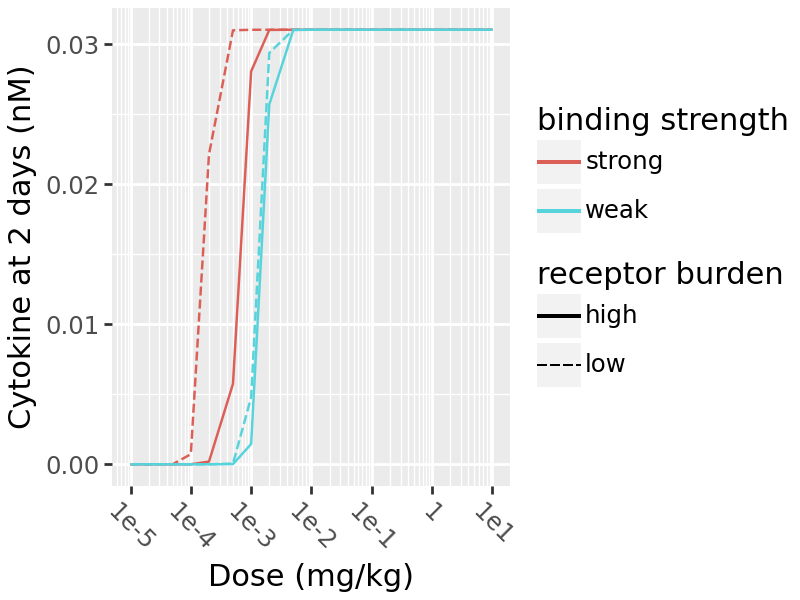

In [12]:
(
    p9.ggplot(result_pandas.query('t == 2 * 24*3600'), p9.aes('dose_mpk', 'value', color='binding_strength', linetype='burden'))
    + p9.geom_line()
    + p9.scale_x_log10(breaks = 10.0**np.arange(-5,2))
    + p9.labs(x = 'Dose (mg/kg)', y = 'Cytokine at 2 days (nM)', color = 'binding strength', linetype = 'receptor burden')
    + p9.theme(figure_size = (4, 3), axis_text_x=p9.element_text(rotation=-45))
)

Or plot your timeseries separated by affinity and target burden:

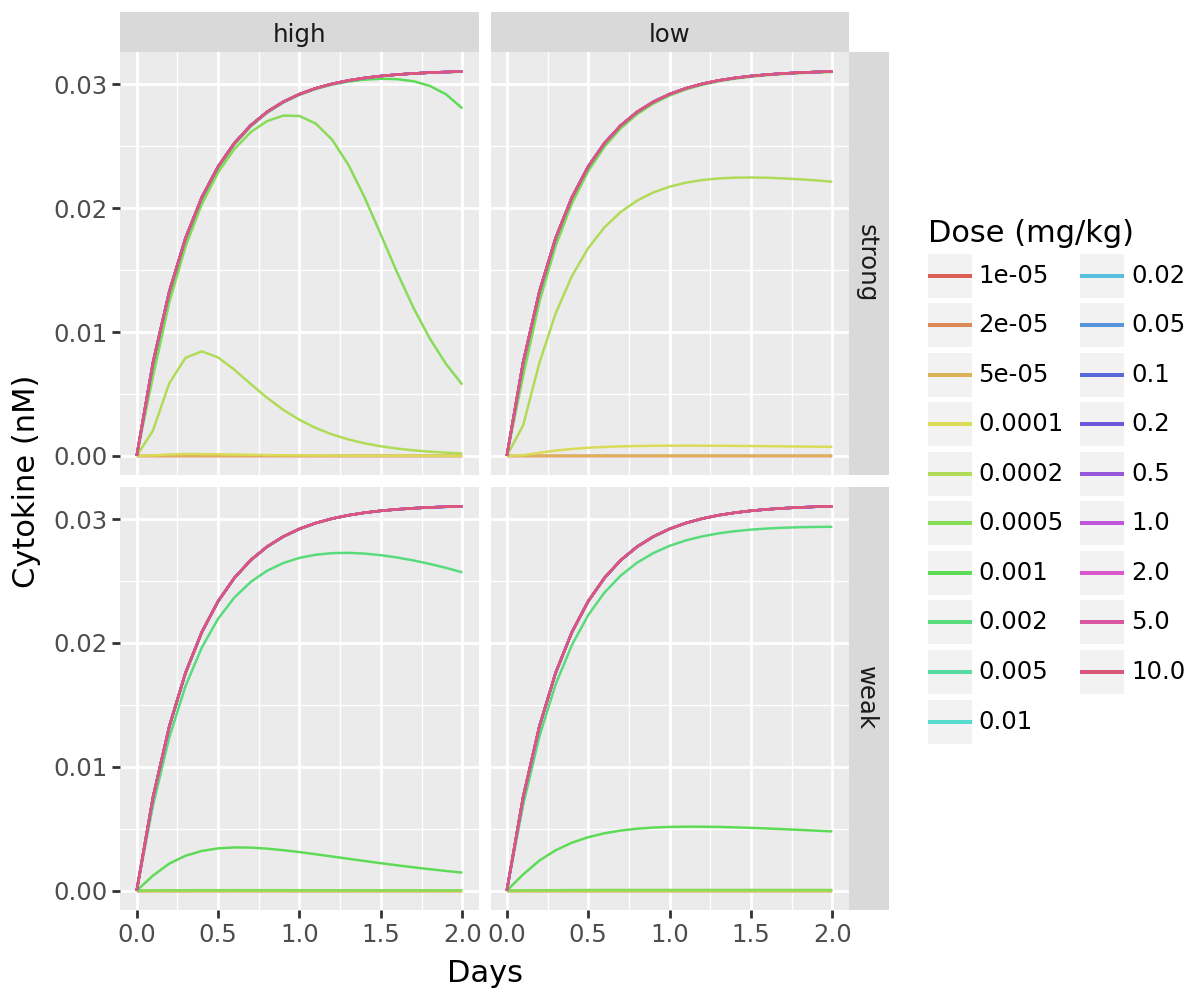

In [13]:
(
p9.ggplot(result_pandas, p9.aes('t /( 24* 3600)', 'value', color='factor(round(dose_mpk,5))'))
    + p9.facet_grid('binding_strength~burden')
    + p9.geom_line()
    + p9.labs(x = 'Days', y = 'Cytokine (nM)', color = 'Dose (mg/kg)', linetype = 'receptor burden')
    + p9.theme(figure_size = (6,5))
)

A few handy non-local expressions (can refer to previous or future states of the system) can be included in model files. Here's an example of running simulations that will return the mean RO over a specified time interval. See the model text file for the expression syntax.

/opt/pixi/cache/envs/abm-platform-training-11393412784987863449/envs/default/lib/python3.12/site-packages/abm/_simulate.py:355: UserWarning: Parameters not present in the model will be ignored: nonexist 


Total: 0, Running: 0, Succeeded: 0, Failed: 0

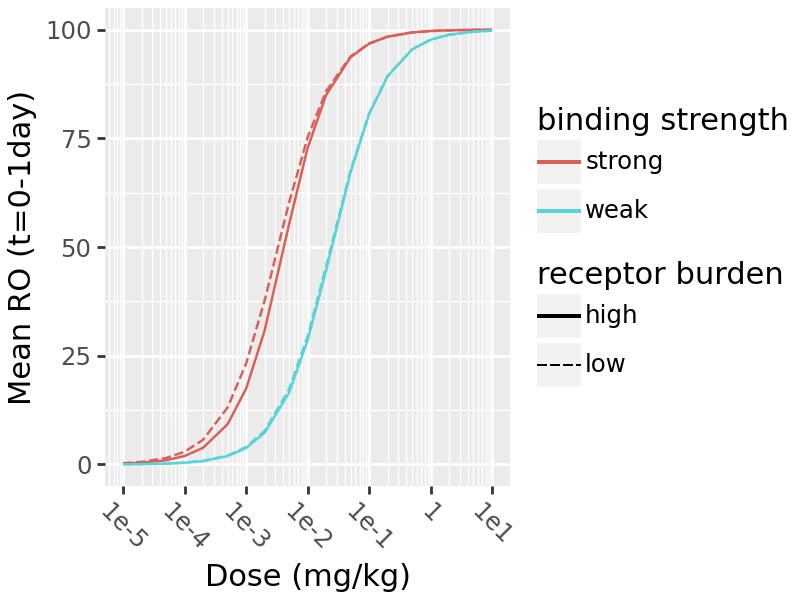

In [14]:
result_pandas = abm.simulate(
    simulations=Tsim, # here you could provide the path to the file containing the simulation table as well.
    models=Tmod,  # here you could provide the path to the file containing the model table as well.
    parameters=Tpar, # here you could provide the path to the file containing the parameter table as well.
    doses=Tdos, # here you could provide the path to the file containing the dose table as well.
    times=["1:d"], # instead of using the Times Table, I used a single array of time outputs for all simulations
    outputs=['mean_receptor_occupancy'],
    linear_solver="KLU",
    reltol=1e-6,
    abstol=1e-8,
    maxord=5,
    nonnegative=False,
).to_pandas(tall_outputs=True)


(
    p9.ggplot(result_pandas, p9.aes('dose_mpk', 'value', color='binding_strength', linetype='burden'))
    + p9.geom_line()
    + p9.scale_x_log10(breaks = 10.0**np.arange(-5,2))
    + p9.labs(x = 'Dose (mg/kg)', y = 'Mean RO (t=0-1day)', color = 'binding strength', linetype = 'receptor burden')
    + p9.theme(figure_size = (4,3), axis_text_x=p9.element_text(rotation=-45))
)

#### Tall versus wide output table

If you would like each output as a separate column instead of in one column, set the `tall_outputs` parameter of either `outputs_pandas` or `outputs_remote` to `False`. The resulting table will have a separate column for each output named after its respective output. This can be easier to use for certain plots, such as when both the `x` and `y` axes correspond to model output values.

NOTE: Currently V2 is only able to output a wide table if your various outputs have different units. To create your own tall table, output a wide table and use `pandas.melt` (example below).

In [15]:
result_pandas = abm.simulate(
    simulations=Tsim, # here you could provide the path to the file containing the simulation table as well.
    models=Tmod,  # here you could provide the path to the file containing the model table as well.
    parameters=Tpar, # here you could provide the path to the file containing the parameter table as well.
    doses=Tdos, # here you could provide the path to the file containing the dose table as well.
    times=["1:d"], # instead of using the Times Table, I used a single array of time outputs for all simulations
    outputs=['receptor_occupancy', 'cytokine_central_nM'],
    linear_solver="KLU",
    reltol=1e-6,
    abstol=1e-8,
    maxord=5,
    nonnegative=False,
).to_pandas(tall_outputs=True)


result_pandas

/opt/pixi/cache/envs/abm-platform-training-11393412784987863449/envs/default/lib/python3.12/site-packages/abm/_simulate.py:355: UserWarning: Parameters not present in the model will be ignored: nonexist 


Total: 0, Running: 0, Succeeded: 0, Failed: 0

,dose_mpk,binding_strength,burden,id,t,output,value,output_unit
0,0.00001,strong,low,0,86400.0,receptor_occupancy,3.077344e-01,1
1,0.00001,strong,low,0,86400.0,cytokine_central_nM,1.022360e-10,nM
2,0.00001,strong,high,1,86400.0,receptor_occupancy,1.256443e-01,1
3,0.00001,strong,high,1,86400.0,cytokine_central_nM,4.435267e-12,nM
4,0.00001,weak,low,2,86400.0,receptor_occupancy,4.146115e-02,1
...,...,...,...,...,...,...,...,...
147,10.00000,strong,high,73,86400.0,cytokine_central_nM,2.921448e-02,nM
148,10.00000,weak,low,74,86400.0,receptor_occupancy,9.975977e+01,1
149,10.00000,weak,low,74,86400.0,cytokine_central_nM,2.921441e-02,nM
150,10.00000,weak,high,75,86400.0,receptor_occupancy,9.975970e+01,1


In [16]:
output_names = ['receptor_occupancy', 'cytokine_central_nM']
result_pandas = abm.simulate(
    simulations=Tsim, # here you could provide the path to the file containing the simulation table as well.
    models=Tmod,  # here you could provide the path to the file containing the model table as well.
    parameters=Tpar, # here you could provide the path to the file containing the parameter table as well.
    doses=Tdos, # here you could provide the path to the file containing the dose table as well.
    times=["1:d"], # instead of using the Times Table, I used a single array of time outputs for all simulations
    outputs=output_names,
    linear_solver="KLU",
    reltol=1e-6,
    abstol=1e-8,
    maxord=5,
    nonnegative=False,
).to_pandas(tall_outputs=True)

result_pandas

/opt/pixi/cache/envs/abm-platform-training-11393412784987863449/envs/default/lib/python3.12/site-packages/abm/_simulate.py:355: UserWarning: Parameters not present in the model will be ignored: nonexist 


Total: 0, Running: 0, Succeeded: 0, Failed: 0

,dose_mpk,binding_strength,burden,id,t,output,value,output_unit
0,0.00001,strong,low,0,86400.0,receptor_occupancy,3.077344e-01,1
1,0.00001,strong,low,0,86400.0,cytokine_central_nM,1.022360e-10,nM
2,0.00001,strong,high,1,86400.0,receptor_occupancy,1.256443e-01,1
3,0.00001,strong,high,1,86400.0,cytokine_central_nM,4.435267e-12,nM
4,0.00001,weak,low,2,86400.0,receptor_occupancy,4.146115e-02,1
...,...,...,...,...,...,...,...,...
147,10.00000,strong,high,73,86400.0,cytokine_central_nM,2.921448e-02,nM
148,10.00000,weak,low,74,86400.0,receptor_occupancy,9.975977e+01,1
149,10.00000,weak,low,74,86400.0,cytokine_central_nM,2.921441e-02,nM
150,10.00000,weak,high,75,86400.0,receptor_occupancy,9.975970e+01,1


# Simulating the 2 compartment Model

The purpose of the 2 compartment model is to demonstrate the standard Applied BioMath method for modeling compartment transport between compartments as well as the Macro- and Micro- parameter methods for modeling reactions. This model contains two identical drugs with identical PK parameters. The two drugs bind to two identical receptors with identical properties. Drug and Receptor #1 are modeled using micro constants, while drug and receptor #2 are modeled using macro constants. Their dynamics should be identical.

## Set up model and tables for 2 compartment model simulations
- Load 2 compartment parameter table
- Modify dose table to contain route from 2 compartment model
- Use 1 compartment simulation table

In [17]:
Tpar2 = pd.read_csv("./tables/par_table_psf_2Compartment.csv")

Tdos2 = copy.deepcopy(Tdos) 
Tdos2['route'] = 'IVboth_mpk'

## Run 2 compartment simulation

In [18]:
result_pandas_2 = abm.simulate(
    simulations=Tsim, # here you could provide the path to the file containing the simulation table as well.
    models='model_files/antireceptor_model_2compartment.txt',  # here you could provide the path to the file containing the model table as well.
    parameters=Tpar2, # here you could provide the path to the file containing the parameter table as well.
    doses=Tdos2, # here you could provide the path to the file containing the dose table as well.
    times=abm.linspace(0,2, 20, 'd'), # instead of using the Times Table, I used a single array of time outputs for all simulations
    outputs=["RO1", "RO2"],
    linear_solver="KLU",
    reltol=1e-6,
    abstol=1e-15,
    maxord=5,
    nonnegative=False
).to_pandas(tall_outputs=True)

Total: 0, Running: 0, Succeeded: 0, Failed: 0

## Plot results
Demonstrate that micro and macro constant parameters produce identical results

In [19]:
def label_type(x):
    if "1" in x:
        return "MicroConstants"
    if "2" in x:
        return "MacroConstants"

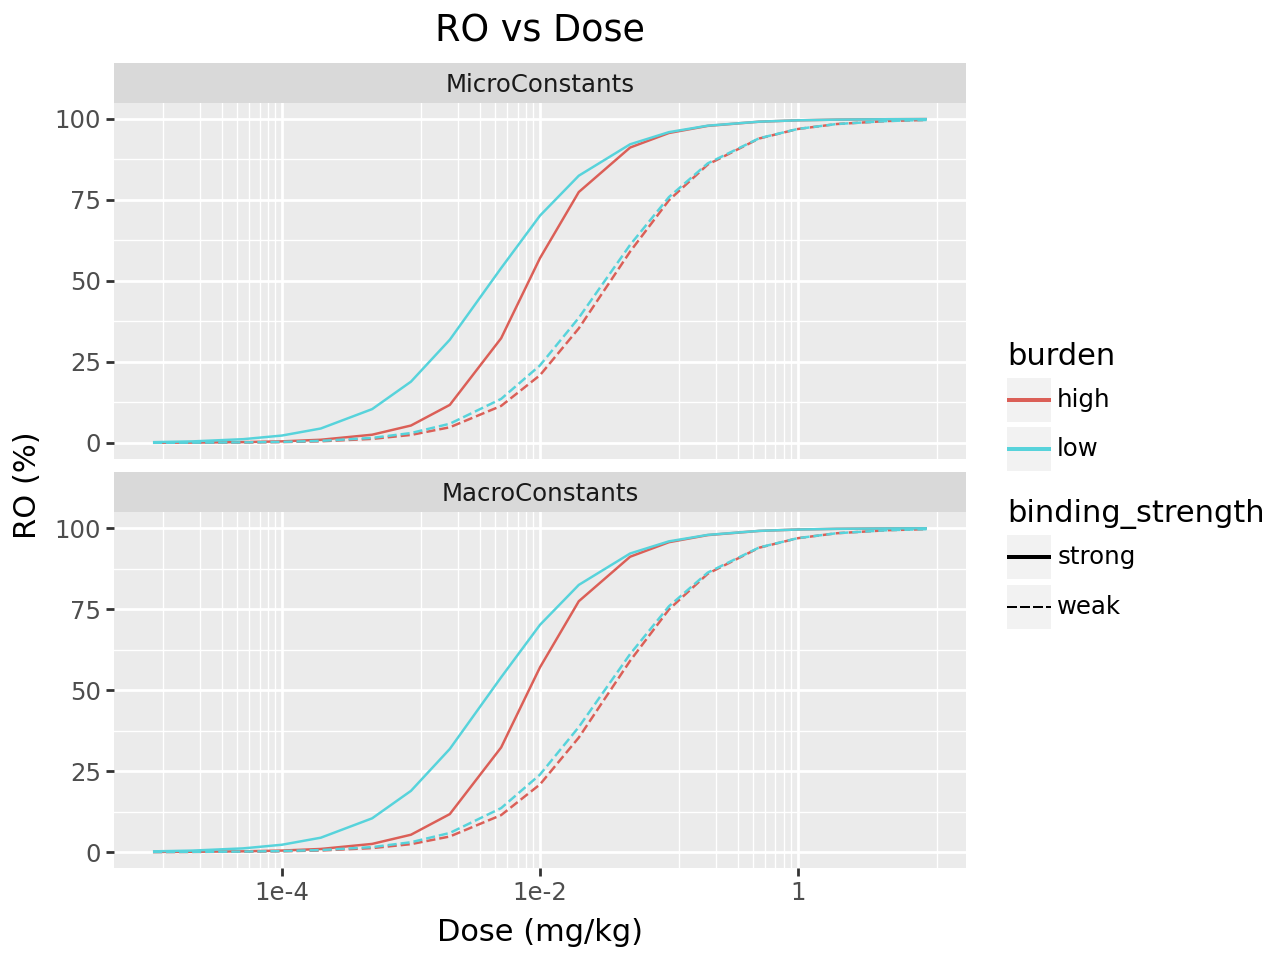

In [20]:
(p9.ggplot()
 + p9.geom_line(data = result_pandas_2.query('t == 2*24*3600'),
             mapping = p9.aes(x = 'dose_mpk', y = 'value', color = 'burden', linetype = 'binding_strength'))
 + p9.scale_x_log10()
 + p9.facet_wrap('output', labeller = label_type, ncol = 1)
 + p9.labs(title='RO vs Dose',
           x='Dose (mg/kg)',
           y='RO (%)'))